<a href="https://colab.research.google.com/github/VyLe/FacialExpression/blob/master/Emotion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Skip training
skip_training = True #Update to True for Test Data 

In [0]:
import os, os.path
from google.colab import drive
import zipfile 
import pandas as pd
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import random 


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
import torch.optim as optim

In [0]:
#Select device for training
device = torch.device("cuda")
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

# Data Loading   

In [0]:
#Import dataset from Google Drive

drive.mount('/content/gdrive')

data_dir = '/content/gdrive/My Drive/DLProject/'


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#LABEL DATA
label_dir = os.path.join(data_dir, 'basic',  'EmoLabel')
labelfile = "list_patition_label.txt"
labels = pd.read_csv(os.path.join(label_dir, labelfile), index_col=False, sep = " ", header = None, names = ['File', 'emotion'])


In [0]:
'''
print(os.getcwd())

#IMAGE DATA
#Put image data into subfolders by each classes
emotion = {1: 'surprise', 2: 'fear', 3: 'disgust', 4: 'happiness', 5: 'sadness', 6: 'anger', 7: 'neutral'}
folderpath = '/content/gdrive/My Drive/DLProject/Images_aligned/aligned/'
tofolder = '/content/gdrive/My Drive/DLProject/'

#Create new folder for each label
for i in ['train', 'test']:
  for j in emotion.keys(): 
    os.makedirs(os.path.join(tofolder, i, str(emotion[j])))


#Iterate over zipfile, extract images and save to corresponding label folders
count_test = 0
count_train = 0

for filename in os.listdir(folderpath):
    if filename != '/content':
          imgname = os.path.basename(filename).replace('_aligned','').replace(' (1)',"")
          img = Image.open(os.path.join(folderpath,filename))
          label = labels[labels['File']==imgname]['emotion'] #Match label of the image
          print(filename,label, count_test, count_train)
          if 'test' in imgname:
            img.save(os.path.join(tofolder, 'test', str(emotion[int(label)]), imgname))
            count_test +=1
          else:
            img.save(os.path.join(tofolder, 'train', str(emotion[int(label)]), imgname))
            count_train += 1
            
print("Finished. Count test: ", count_test, '. Count train: ',count_train)
'''

'\nprint(os.getcwd())\n\n#IMAGE DATA\n#Put image data into subfolders by each classes\nemotion = {1: \'surprise\', 2: \'fear\', 3: \'disgust\', 4: \'happiness\', 5: \'sadness\', 6: \'anger\', 7: \'neutral\'}\nfolderpath = \'/content/gdrive/My Drive/DLProject/Images_aligned/aligned/\'\ntofolder = \'/content/gdrive/My Drive/DLProject/\'\n\n#Create new folder for each label\nfor i in [\'train\', \'test\']:\n  for j in emotion.keys(): \n    os.makedirs(os.path.join(tofolder, i, str(emotion[j])))\n\n\n#Iterate over zipfile, extract images and save to corresponding label folders\ncount_test = 0\ncount_train = 0\n\nfor filename in os.listdir(folderpath):\n    if filename != \'/content\':\n          imgname = os.path.basename(filename).replace(\'_aligned\',\'\').replace(\' (1)\',"")\n          img = Image.open(os.path.join(folderpath,filename))\n          label = labels[labels[\'File\']==imgname][\'emotion\'] #Match label of the image\n          print(filename,label, count_test, count_train)\n

In [0]:
#Read train and test dataset 
TRAIN_DATA_PATH = "/content/gdrive/My Drive/DLProject/train"
TEST_DATA_PATH = "/content/gdrive/My Drive/DLProject/test"
TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(100,100),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,), (0.5,))
    ])

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_loader = data.DataLoader(train_data, batch_size=32, shuffle=True)
test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_loader  = data.DataLoader(test_data, batch_size=5, shuffle=False) 


```
# DATA DESCRIPTION 
```

In [0]:
print("Number of train samples: ", len(train_data))
print("Number of test samples: ", len(test_data))
print("Detected Classes are: ", train_data.class_to_idx) # classes are detected by folder structure


Number of train samples:  12271
Number of test samples:  3068
Detected Classes are:  {'anger': 0, 'disgust': 1, 'fear': 2, 'happiness': 3, 'neutral': 4, 'sadness': 5, 'surprise': 6}


# VGG

In [0]:
class VGG(nn.Module):
    def __init__(self, n_channels=32):

        super(VGG, self).__init__()
        n = n_channels
        #Block 1
        self.conv11 = nn.Conv2d(3, n, 3, padding = 1) #Change 1 to 3
        self.conv11_bn = nn.BatchNorm2d(n)
        self.conv12 = nn.Conv2d(n, n, 3, padding = 1)
        self.conv12_bn = nn.BatchNorm2d(n)        
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride = 2)
        # Add dropout 
        
        
        #Block 2
        self.conv21 = nn.Conv2d(n, 2*n, 3, padding = 1)
        self.conv21_bn = nn.BatchNorm2d(2*n)
        self.conv22 = nn.Conv2d(2*n, 2*n, 3, padding = 1)
        self.conv22_bn = nn.BatchNorm2d(2*n)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride = 2)       

        self.conv3 = nn.Conv2d(2*n, 3*n, 3)
        self.conv3_bn = nn.BatchNorm2d(3*n)

        self.conv4 = nn.Conv2d(3*n, 2*n, 1)
        self.conv4_bn = nn.BatchNorm2d(2*n)

        self.conv5 = nn.Conv2d(2*n, n, 1)
        self.conv5_bn = nn.BatchNorm2d(n)

        self.avgpool = nn.AvgPool2d(kernel_size = 5)
                
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 7)


    def forward(self, x, verbose=False):
        if verbose: print(x.shape)
        x = F.relu(self.conv11_bn(self.conv11(x)))
        x = F.relu(self.conv12_bn(self.conv12(x)))

        if verbose: print("conv1", x.shape)
        x = self.maxpool1(x)
        if verbose: print('maxpool1:', x.shape)

        x = F.relu(self.conv21_bn(self.conv21(x)))
        x = F.relu(self.conv22_bn(self.conv22(x)))
        if verbose: print('conv2', x.shape)
        x = self.maxpool2(x)
        if verbose: print('maxpool2:', x.shape)
        
        x = F.relu(self.conv3_bn(self.conv3(x)))
        if verbose: print('conv3', x.shape)

        x = F.relu(self.conv4_bn(self.conv4(x)))
        if verbose: print('conv4',x.shape)

        x = F.relu(self.conv5_bn(self.conv5(x)))
        if verbose: print('conv5',x.shape)
          
        x = self.avgpool(x)
        if verbose: print('avgpool:', x.shape)

        x = x.view(x.size(0), -1)
        if verbose: print('x flatten:', x.shape)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        if verbose: print('out :', x.shape)

        return x 

In [0]:
#Testing the shape of output 
net = VGG()
net.to(device)

with torch.no_grad():
    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.to(device)
    print('Shape of the input tensor:', images.shape)

    y = net(images, verbose=True)
    assert y.shape == torch.Size([32, 7]), "Bad shape of y: y.shape={}".format(y.shape)

print('The shapes seem to be ok.')

Shape of the input tensor: torch.Size([32, 3, 100, 100])
torch.Size([32, 3, 100, 100])
conv1 torch.Size([32, 32, 100, 100])
maxpool1: torch.Size([32, 32, 50, 50])
conv2 torch.Size([32, 64, 50, 50])
maxpool2: torch.Size([32, 64, 25, 25])
conv3 torch.Size([32, 96, 23, 23])
conv4 torch.Size([32, 64, 23, 23])
conv5 torch.Size([32, 32, 23, 23])
avgpool: torch.Size([32, 32, 4, 4])
x flatten: torch.Size([32, 512])
out : torch.Size([32, 7])
The shapes seem to be ok.


# Model Training

In [0]:
import gc
gc.collect()

0

In [0]:
def compute_accuracy(net, testloader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [0]:
import sklearn.metrics as skmetrics
import seaborn as sns
classes = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']

def confusion_matrix(net, testloader):
    net.eval()
    true_labels = []
    predictions = []
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            predicted = torch.argmax(outputs.data, 1)
            true_labels.append(labels.cpu().numpy())
            predictions.append(predicted.cpu().numpy())
    true_labels = np.hstack(true_labels)
    predictions = np.hstack(predictions)

    c_matrix = skmetrics.confusion_matrix(true_labels, predictions)
    figure = plt.figure(figsize=(6, 6))
    plt.title("Confusion matrix")
    sns.heatmap(c_matrix, cmap='Blues', annot=True, xticklabels=classes, yticklabels=classes, fmt='g', cbar=False)
    plt.xlabel('predictions')
    plt.ylabel('true labels')



In [0]:
import gc
gc.collect()

net = VGG()
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)
n_epochs = 20

net.train()
for epoch in range(n_epochs):
    running_loss = 0.0
    print_every = 200  # mini-batches
    for i, (inputs, labels) in enumerate(train_loader, 0):
        # Transfer to GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i % print_every) == (print_every-1):
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/print_every))
            running_loss = 0.0
        if skip_training:
            break

    # Print accuracy after every epoch
    accuracy= compute_accuracy(net, test_loader)
    print('Accuracy of the network on the 3068 test images: %d %%' % (100 * accuracy))

    if skip_training:
        break

print('Finished Training')

[1,   200] loss: 1.628
Accuracy of the network on the 3068 test images: 50 %
[2,   200] loss: 1.413
Accuracy of the network on the 3068 test images: 56 %
[3,   200] loss: 1.222
Accuracy of the network on the 3068 test images: 59 %
[4,   200] loss: 1.151
Accuracy of the network on the 3068 test images: 61 %
[5,   200] loss: 1.052
Accuracy of the network on the 3068 test images: 64 %
[6,   200] loss: 0.974
Accuracy of the network on the 3068 test images: 64 %
[7,   200] loss: 0.948
Accuracy of the network on the 3068 test images: 66 %
[8,   200] loss: 0.904
Accuracy of the network on the 3068 test images: 66 %
[9,   200] loss: 0.863
Accuracy of the network on the 3068 test images: 67 %
[10,   200] loss: 0.835
Accuracy of the network on the 3068 test images: 69 %
[11,   200] loss: 0.784
Accuracy of the network on the 3068 test images: 69 %
[12,   200] loss: 0.793
Accuracy of the network on the 3068 test images: 70 %
[13,   200] loss: 0.739
Accuracy of the network on the 3068 test images: 

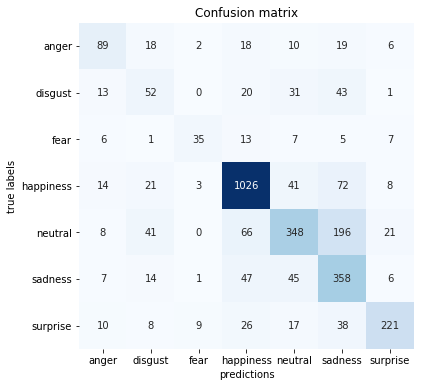

In [0]:
confusion_matrix(net, test_loader)

In [0]:
#Save model 
filename = os.path.join(data_dir,'vgg_aligned.pth')
if not skip_training:
    try:
        do_save = input('Do you want to save the model (type yes to confirm)? ').lower()
        if do_save == 'yes':
            torch.save(net.state_dict(), filename)
            print('Model saved to %s' % filename)
        else:
            print('Model not saved')
    except:
        raise Exception('The notebook should be run or validated with skip_training=True.')
else:
    net = VGG()
    net.load_state_dict(torch.load(filename, map_location=lambda storage, loc: storage))
    net.to(device)
    print('Model loaded from %s' % filename)

Model loaded from /content/gdrive/My Drive/DLProject/vgg_aligned.pth


# Fine Tuning 


In [0]:
import gc
gc.collect()

net = VGG()
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)
n_epochs = 20

net.train()
for epoch in range(n_epochs):
    running_loss = 0.0
    print_every = 200  # mini-batches
    for i, (inputs, labels) in enumerate(train_loader, 0):
        # Transfer to GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i % print_every) == (print_every-1):
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/print_every))
            running_loss = 0.0
        if skip_training:
            break

    # Print accuracy after every epoch
    accuracy = compute_accuracy(net, test_loader)
    print('Accuracy of the network on the 3068 test images: %d %%' % (100 * accuracy))

    if skip_training:
        break


print('Finished Training')

KeyboardInterrupt: ignored

In [0]:
#Save model 
skip_training = True 
filename = os.path.join(data_dir,'vgg_SGD.pth')
if not skip_training:
    try:
        do_save = input('Do you want to save the model (type yes to confirm)? ').lower()
        if do_save == 'yes':
            torch.save(net.state_dict(), filename)
            print('Model saved to %s' % filename)
        else:
            print('Model not saved')
    except:
        raise Exception('The notebook should be run or validated with skip_training=True.')
else:
    net_SGD = VGG()
    net_SGD.load_state_dict(torch.load(filename, map_location=lambda storage, loc: storage))
    net_SGD.to(device)
    print('Model loaded from %s' % filename)

Model loaded from /content/gdrive/My Drive/DLProject/vgg_SGD.pth


0.728161668839635


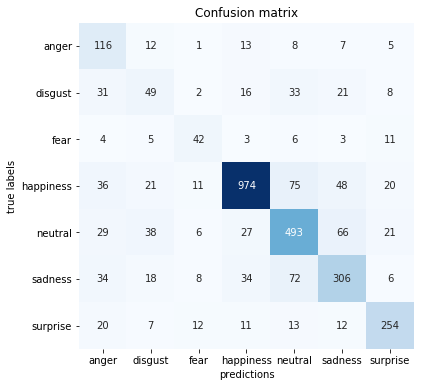

In [0]:
print(compute_accuracy(net_SGD, test_loader))
confusion_matrix(net_SGD, test_loader)

In [0]:
#Hyperparameter tuning 

import gc
gc.collect()
import itertools


def grid_search(*iterables):

    return itertools.product(*iterables)


def train(learning_rate, optimizer, number_epochs, wd):
  net_tunning = VGG()
  net_tunning.to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = optimizer(net_tunning.parameters(), lr=learning_rate, weight_decay = wd)
  n_epochs = number_epochs
  
  test_accuracy_history = []
  test_errors = []  # Keep track of the test error

  net_tunning.train()

  for epoch in range(n_epochs):
      running_loss = 0.0
      print_every = 200
      for i, (inputs, labels) in enumerate(train_loader, 0):
          # Transfer to GPU
          inputs, labels = inputs.to(device), labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net_tunning(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()

          if (i % print_every) == (print_every-1):
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/print_every))
            running_loss = 0.0

          if skip_training:
            break
      # Print accuracy after every epoch
      accuracy = compute_accuracy(net_tunning, test_loader)
      print('Accuracy of the network on the 3068 test images: %d %%' % (100 * accuracy))
      test_accuracy_history.append(accuracy)

  print('Finished Training')
  return net_tunning, test_accuracy_history
  
  


In [0]:
lrate_range = [0.005, 0.01, 0.05]  # lower and upper boundaries for parameter 1 
n_epochs = [50]
optimizers = [optim.SGD]
weightdecay = [0.001, 0.010]

hyperparameters = []
accuracies = []

if not skip_training:
    for (lrate, opt, n_epoch, wd) in grid_search(lrate_range, optimizers, n_epochs, weightdecay):
        hyperparameters.append([lrate, opt, n_epoch, wd])
        print('Hyperparameters: ', hyperparameters[-1])
        network, test_accuracy_history = train(lrate, opt,  n_epoch, wd)
        accuracies.append(test_accuracy_history[-1])
        print('Final accuracy:', accuracies[-1])


Hyperparameters:  [0.005, <class 'torch.optim.sgd.SGD'>, 50, 0.001]
[1,   200] loss: 1.721
Accuracy of the network on the 3068 test images: 38 %
[2,   200] loss: 1.559
Accuracy of the network on the 3068 test images: 48 %
[3,   200] loss: 1.363
Accuracy of the network on the 3068 test images: 53 %
[4,   200] loss: 1.207
Accuracy of the network on the 3068 test images: 58 %
[5,   200] loss: 1.060
Accuracy of the network on the 3068 test images: 54 %
[6,   200] loss: 0.962
Accuracy of the network on the 3068 test images: 61 %
[7,   200] loss: 0.880
Accuracy of the network on the 3068 test images: 64 %
[8,   200] loss: 0.833
Accuracy of the network on the 3068 test images: 65 %
[9,   200] loss: 0.801
Accuracy of the network on the 3068 test images: 66 %
[10,   200] loss: 0.765
Accuracy of the network on the 3068 test images: 71 %
[11,   200] loss: 0.708
Accuracy of the network on the 3068 test images: 71 %
[12,   200] loss: 0.684
Accuracy of the network on the 3068 test images: 72 %
[13, 

In [0]:
hyperparameters = np.array(hyperparameters)
accuracies = np.array(accuracies)

In [0]:

hs_filename = os.path.join(data_dir,'grid_search.npz')
if not skip_training:
    try:
        do_save = input('Do you want to save the results of hyperparameter search (type yes to confirm)? ').lower()
        if do_save == 'yes':
            np.savez(hs_filename,
                     hyperparameters=hyperparameters,
                     accuracies=accuracies)
            print('Results saved to %s' % hs_filename)
        else:
            print('Results not saved')
    except:
        raise Exception('The notebook should be run or validated with skip_training=True.')
else:
    rs = np.load(hs_filename, allow_pickle=True)
    hyperparameters = rs['hyperparameters']
    accuracies = rs['accuracies']
    print('Results loaded from %s' % hs_filename)

Results loaded from /content/gdrive/My Drive/DLProject/grid_search.npz


In [0]:
print('lrate_range optimizers n_epochs weightdecay')
ix = accuracies.argsort()[-1::-1]
for (lrate, opt, n_epoch, wd), accuracy in zip(hyperparameters[ix], accuracies[ix]):
    print('%6.3f %s %2d %7.3f %8.3f' % (lrate, opt, n_epoch, wd, accuracy))

lrate_range optimizers n_epochs weightdecay
 0.005 <class 'torch.optim.sgd.SGD'> 50   0.001    0.763
 0.005 <class 'torch.optim.sgd.SGD'> 50   0.010    0.760
 0.010 <class 'torch.optim.sgd.SGD'> 50   0.010    0.750
 0.010 <class 'torch.optim.sgd.SGD'> 50   0.001    0.741
 0.050 <class 'torch.optim.sgd.SGD'> 50   0.001    0.734
 0.050 <class 'torch.optim.sgd.SGD'> 50   0.010    0.616


In [0]:
#Another Fine Tuning Test

lrate_range = [0.002, 0.005]  
optimizers = [optim.SGD, optim.Adam]
weightdecay = [0.001, 0.005]

hyperparameters = []
accuracies = []

if not skip_training:
    for (lrate, opt, n_epoch, wd) in grid_search(lrate_range, optimizers, n_epochs, weightdecay):
        hyperparameters.append([lrate, opt, n_epoch, wd])
        print('Hyperparameters: ', hyperparameters[-1])
        network, test_accuracy_history = train(lrate, opt,  n_epoch, wd)
        accuracies.append(test_accuracy_history[-1])
        print('Final accuracy:', accuracies[-1])



# Data Transformation 


In [0]:

TRAIN_DATA_PATH = "/content/gdrive/My Drive/DLProject/train"
TEST_DATA_PATH = "/content/gdrive/My Drive/DLProject/test"
TRANSFORM_IMG_TRAIN = transforms.Compose([
    transforms.Resize(100,100),
    transforms.RandomHorizontalFlip( p = 0.2),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,), (0.5,))
    ])

TRANSFORM_IMG_TEST = transforms.Compose([
    transforms.Resize(100,100),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,), (0.5,))
    ])



train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG_TRAIN)
train_loader = data.DataLoader(train_data, batch_size=32, shuffle=True)
test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG_TEST)
test_loader  = data.DataLoader(test_data, batch_size=5, shuffle=False) 



In [0]:
skip_training = False 
import gc
gc.collect()

net = VGG()
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.005, weight_decay = 0.001)
n_epochs = 50

net.train()
for epoch in range(n_epochs):
    running_loss = 0.0
    print_every = 200  # mini-batches
    for i, (inputs, labels) in enumerate(train_loader, 0):
        # Transfer to GPU
        inputs, labels = inputs.to(device), labels.to(device)

        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i % print_every) == (print_every-1):
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/print_every))
            running_loss = 0.0
        if skip_training:
            break

    # Print accuracy after every epoch
    accuracy = compute_accuracy(net, test_loader)
    print('Accuracy of the network on the 3068 test images: %d %%' % (100 * accuracy))

    if skip_training:
        break


print('Finished Training')

[1,   200] loss: 1.735
Accuracy of the network on the 3068 test images: 38 %
[2,   200] loss: 1.562
Accuracy of the network on the 3068 test images: 46 %
[3,   200] loss: 1.357
Accuracy of the network on the 3068 test images: 56 %
[4,   200] loss: 1.211
Accuracy of the network on the 3068 test images: 55 %
[5,   200] loss: 1.083
Accuracy of the network on the 3068 test images: 59 %
[6,   200] loss: 0.992
Accuracy of the network on the 3068 test images: 56 %
[7,   200] loss: 0.938
Accuracy of the network on the 3068 test images: 61 %
[8,   200] loss: 0.868
Accuracy of the network on the 3068 test images: 63 %
[9,   200] loss: 0.834
Accuracy of the network on the 3068 test images: 72 %
[10,   200] loss: 0.784
Accuracy of the network on the 3068 test images: 71 %
[11,   200] loss: 0.747
Accuracy of the network on the 3068 test images: 68 %
[12,   200] loss: 0.727
Accuracy of the network on the 3068 test images: 71 %
[13,   200] loss: 0.709
Accuracy of the network on the 3068 test images: 

# VGG  2

In [0]:
class VGG2(nn.Module):
    def __init__(self, n_channels=32):

        super(VGG2, self).__init__()
        n = n_channels
        #Block 1
        self.conv11 = nn.Conv2d(3, n, 3, padding = 1) #Change 1 to 3
        self.conv11_bn = nn.BatchNorm2d(n)
        self.conv12 = nn.Conv2d(n, n, 3, padding = 1)
        self.conv12_bn = nn.BatchNorm2d(n)        
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride = 2)
        
        #Block 2
        self.conv21 = nn.Conv2d(n, 2*n, 3, padding = 1)
        self.conv21_bn = nn.BatchNorm2d(2*n)
        self.conv22 = nn.Conv2d(2*n, 2*n, 3, padding = 1)
        self.conv22_bn = nn.BatchNorm2d(2*n)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride = 2)       

        #Block 3
        self.conv31 = nn.Conv2d(2*n, 4*n, 3, padding = 1)
        self.conv31_bn = nn.BatchNorm2d(4*n)

        #Block 4
        self.conv41 = nn.Conv2d(4*n, 8*n, 1)
        self.conv41_bn = nn.BatchNorm2d(8*n)
        
        #Block 5
        self.conv51 = nn.Conv2d(8*n, 8*n, 1)
        self.conv51_bn = nn.BatchNorm2d(8*n)
        
        self.avgpool = nn.AvgPool2d(kernel_size = 5)
        
        self.fc1 = nn.Linear(6400, 256)
        self.fc2 = nn.Linear(256, 7)


    def forward(self, x, verbose=False):
        if verbose: print(x.shape)
        x = F.relu(self.conv11_bn(self.conv11(x)))
        x = F.relu(self.conv12_bn(self.conv12(x)))

        if verbose: print("conv1", x.shape)
        x = self.maxpool1(x)
        if verbose: print('maxpool1:', x.shape)

        x = F.relu(self.conv21_bn(self.conv21(x)))
        x = F.relu(self.conv22_bn(self.conv22(x)))
        if verbose: print('conv2', x.shape)
        x = self.maxpool2(x)
        if verbose: print('maxpool2:', x.shape)
        
        x = F.relu(self.conv31_bn(self.conv31(x)))
        if verbose: print('conv3', x.shape)
 
        x = F.relu(self.conv41_bn(self.conv41(x)))
        if verbose: print('conv4',x.shape)

        x = F.relu(self.conv51_bn(self.conv51(x)))
        if verbose: print('conv5',x.shape)
          
        x = self.avgpool(x)
        if verbose: print('avgpool:', x.shape)

        x = x.view(x.size(0), -1)
        if verbose: print('x flatten:', x.shape)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        if verbose: print('out :', x.shape)

        return x 

In [0]:
import gc
gc.collect()

net = VGG()
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.005, weight_decay = 0.001)
n_epochs = 50

net.train()
for epoch in range(n_epochs):
    running_loss = 0.0
    print_every = 200  # mini-batches
    for i, (inputs, labels) in enumerate(train_loader, 0):
        # Transfer to GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i % print_every) == (print_every-1):
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/print_every))
            running_loss = 0.0
        if skip_training:
            break

    # Print accuracy after every epoch
    accuracy = compute_accuracy(net, test_loader)
    print('Accuracy of the network on the 3068 test images: %d %%' % (100 * accuracy))

    if skip_training:
        break

print('Finished Training')

In [0]:
#Save model 
filename = os.path.join(data_dir,'vgg_2.pth')
if not skip_training:
    try:
        do_save = input('Do you want to save the model (type yes to confirm)? ').lower()
        if do_save == 'yes':
            torch.save(net.state_dict(), filename)
            print('Model saved to %s' % filename)
        else:
            print('Model not saved')
    except:
        raise Exception('The notebook should be run or validated with skip_training=True.')
else:
    net = VGG()
    net.load_state_dict(torch.load(filename, map_location=lambda storage, loc: storage))
    net.to(device)
    print('Model loaded from %s' % filename)

#Result

In [0]:
print(compute_accuracy(net, test_loader))
confusion_matrix(net, test_loader)

In [0]:
classes = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']

    
# Display random images from the test set, the ground truth labels and the network's predictions
net.eval()
with torch.no_grad():
       dataiter = iter(test_loader)
       images, labels = dataiter.next()
       outputs = net(images)
       out = torchvision.utils.make_grid(images)
       predicted = torch.argmax(outputs.data, 1)
       imshow(out)     
       print('Ground truth labels: ', ' '.join('%10s' % classes[labels[j]] for j in range(5)))
       print('Predictions:         ', ' '.join('%10s' % classes[j] for j in predicted))
       
